#  Fashion-MNIST

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

In [2]:
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

## Data Set

### Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

### Loading the Dataset

As usual, we want to load the data into `torch.tensor` and apply a transformation so that the data is normalised in order to reduce data skewness. Therefore we start by definint a composition of transformations that transform the data to `torch.tensor` and apply a normalisation operation:

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Array to PyTorch tensor
        transforms.Normalize((0.5,), (0.5,)), # Normalisation (mean and std)
    ]
)

Using the transformation we can now download the dataset. We start by downloading the training dataset:

In [5]:
# Download and load the training dataset
trainset = datasets.FashionMNIST("data", download=True, train=True, transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

The training dataset is used for training and therefore the model weights will be iteratively changed to minimise the loss on this dataset. Using this dataset to evaluate or model performance would not be fair and therefore there is a second dataset for this purpose:

In [6]:
# Download and load the test dataset
testset = datasets.FashionMNIST("data", download=True, train=False, transform=transform)

# Create a data loader for the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, drop_last=True)

### Visualizing Images and Labels

In [7]:
label_to_name = { 
    i : name 
    for i, name in enumerate("T-Shirt Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()) 
}

print(label_to_name)

{0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Boot'}


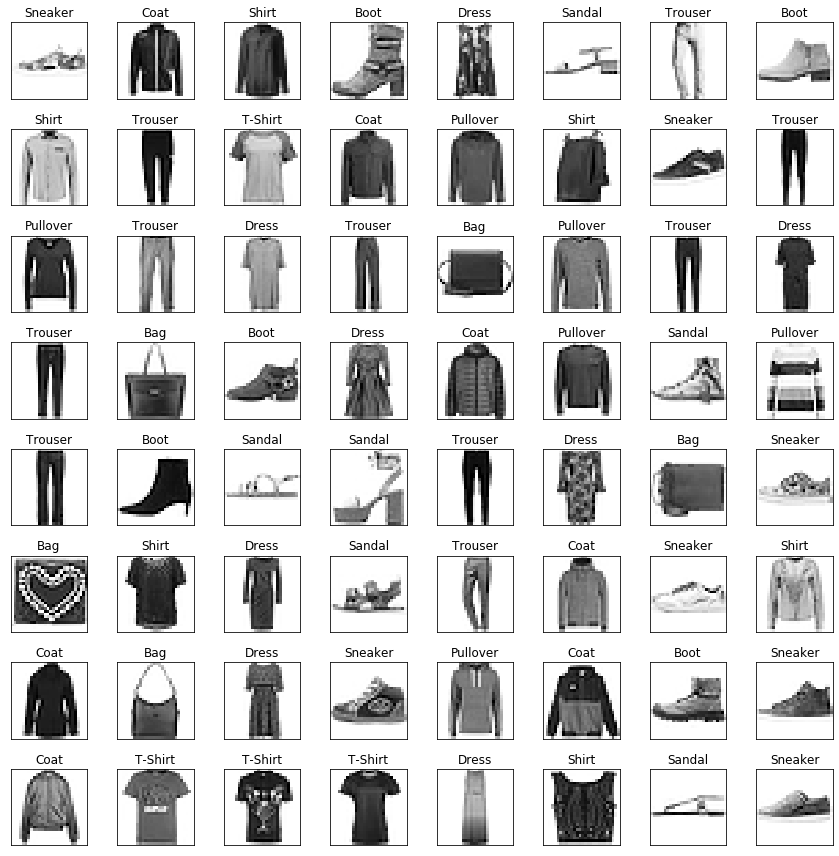

In [8]:
dataiter = iter(trainloader) # Create an iterator from trainloader

images, labels = next(dataiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    img = (images[idx].numpy().squeeze() + 0.5) * 0.5 # Un-normalize image
    plt.imshow(img, cmap='Greys')
    
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Neural Network with PyTorch

Simple neural networks in PyTorch can be easily and quickly defined using the `nn.Sequentual` class that accepts a list of layers to which the data is passed sequentually. However, for more complex architectures this class is not sufficient. More compelx architectures are usually defined by sub-classing a `nn.Module`. Even if for a multi-layer percepton the `nn.Sequentual` would be enough, let's try to sub-class the `nn.Module`:

In [9]:
class FashionClassifier(nn.Module):
    
    def __init__(self):
        # Initialise nn.Module superclass
        super().__init__()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        """
        Define forward pass through the network.
        """
        
        # Flatten images (64, 1, 28, 28) to (64, 1 * 28 * 28)
        x = x.view(x.shape[0], -1)
        
        # Input: (64, 784)
        assert x.shape == (64, 784)
        
        x = self.fc1(x) # Fully connected layer
        x = F.relu(x) # Activation
        x = self.fc2(x) # Fully connected layer
        x = F.relu(x) # Activation
        x = self.fc3(x) # Fully connected layer
        
        # Output: (64, 10)
        assert x.shape == (64, 10)
        
        # Produce log-probabilities for the 10 classes
        x = F.log_softmax(x, dim=1)
        
        return x

In [10]:
# Instanciate the model
model = FashionClassifier()

### Test Forward Pass

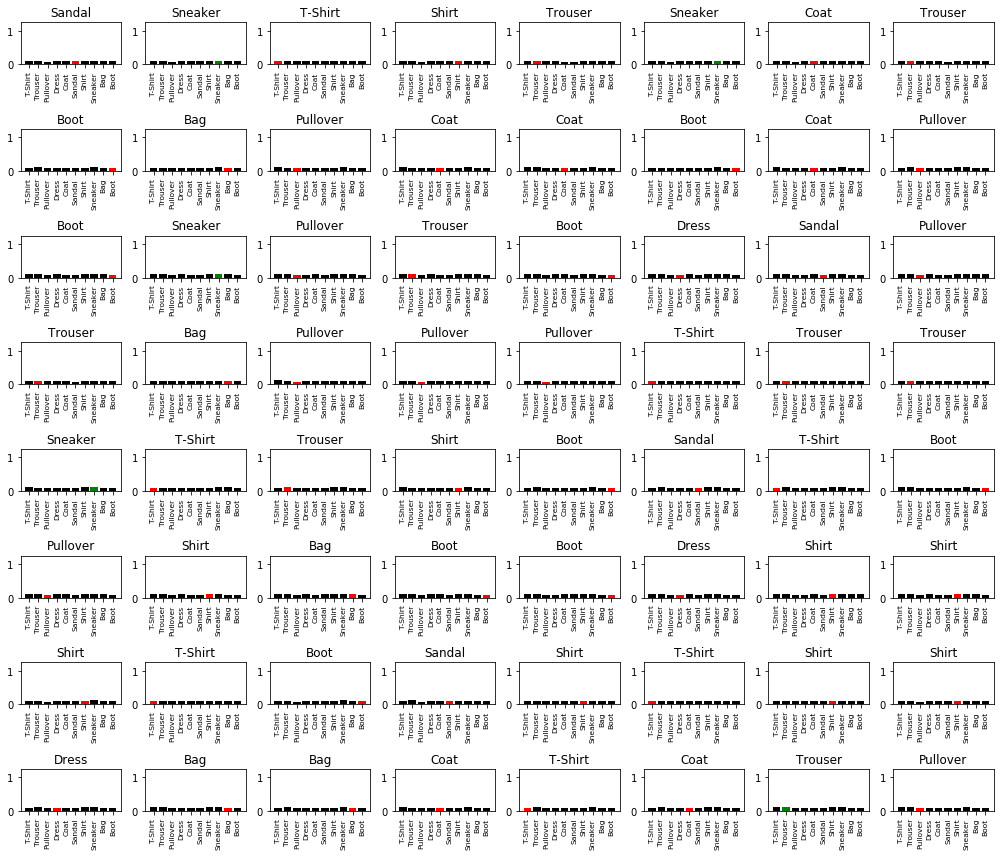

In [11]:
images, labels = next(dataiter)

def showclassp(images, labels, model, misclassified=False):
    """
    Plot class probabilities for a batch of images and labels.
    """
    
    from collections import namedtuple
    
    # Define named tuple for misclassified images
    # Clearer for printing, reporting batch index and true label
    Misclassified = namedtuple("Misclassified", "index true_label")
    
    # Defint a figure
    fig = plt.figure(figsize=(14,12))
    
    # List of missclassified systems
    failed = []
    
    # Loop over images and labels in a batch
    for idx in range(64):
        
        # Create subplot
        ax = fig.add_subplot(8, 8, idx + 1, xticks=range(10), yticks=[0, 1])

        # Flatten image for forward pass
        images = images.view(images.shape[0], -1)

        
        with torch.no_grad(): # Do not track gradients
            # Perform forward pass
            out = model(images)
            
            # Compute class probabilities
            # The model returns log-probabilities
            p = torch.exp(out).numpy()

        # Plot all class probabilities for given image
        for i in range(10):
            if labels[idx] == i:
                if labels[idx] == np.argmax(p[idx]):
                    plt.bar(i, p[idx,i], color="g")
                else:
                    plt.bar(i, p[idx,i], color="r")
                    
                    # Append misclassified sample
                    failed.append(Misclassified(idx, np.argmax(p[idx])))
            else:
                plt.bar(i, p[idx,i], color="k")
        plt.ylim([0,1.25])
        
        ax.set_xticklabels(label_to_name.values(), rotation=90, fontdict={"fontsize": 7.5})
        
        name = label_to_name[labels[idx].item()]
        ax.set_title(name, fontdict={"fontsize": 12})

    plt.tight_layout()
    plt.show()
    
    return failed if misclassified else  None
    
showclassp(images, labels, model)

### Training

The cross-entropy loss applied to the output of a fully connected layer (*logit*) corresponds to the negative log likelihood loss applied to a log-softmax output. Since out model applies a `F.log_softmax` function at the end of the forward pass, our log function will have to be the `nn.NLLLoss` in order to produce the same output of `nn.CrossEntropyLoss` applied to the logits.

In [12]:
nnl_loss = nn.NLLLoss()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [14]:
# Define the number of training. epochs
epochs = 5

# Loop over epochs
for epoch in range(epochs):
    
    # Initialize total epoch loss
    epoch_loss = 0
    
    # Loop over batches
    for images, labels in trainloader:
        
        # Flatten input image
        images = images.view(images.shape[0], -1)
    
        # Initialize the gradients to zero
        optimizer.zero_grad()
        
        # Perform forward pass
        output = model(images)
        
        # Compute the loss
        loss = nnl_loss(output, labels)
        
        # Perform backpropagation
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Accumulate total epoch loss
        epoch_loss += loss.item()
    else:
        print(f"Loss #{epoch}: {epoch_loss/len(trainloader)}")

Loss #0: 0.4921326091634298
Loss #1: 0.38545002592697725
Loss #2: 0.3520053313168416
Loss #3: 0.3287039633001436
Loss #4: 0.31253494937748133


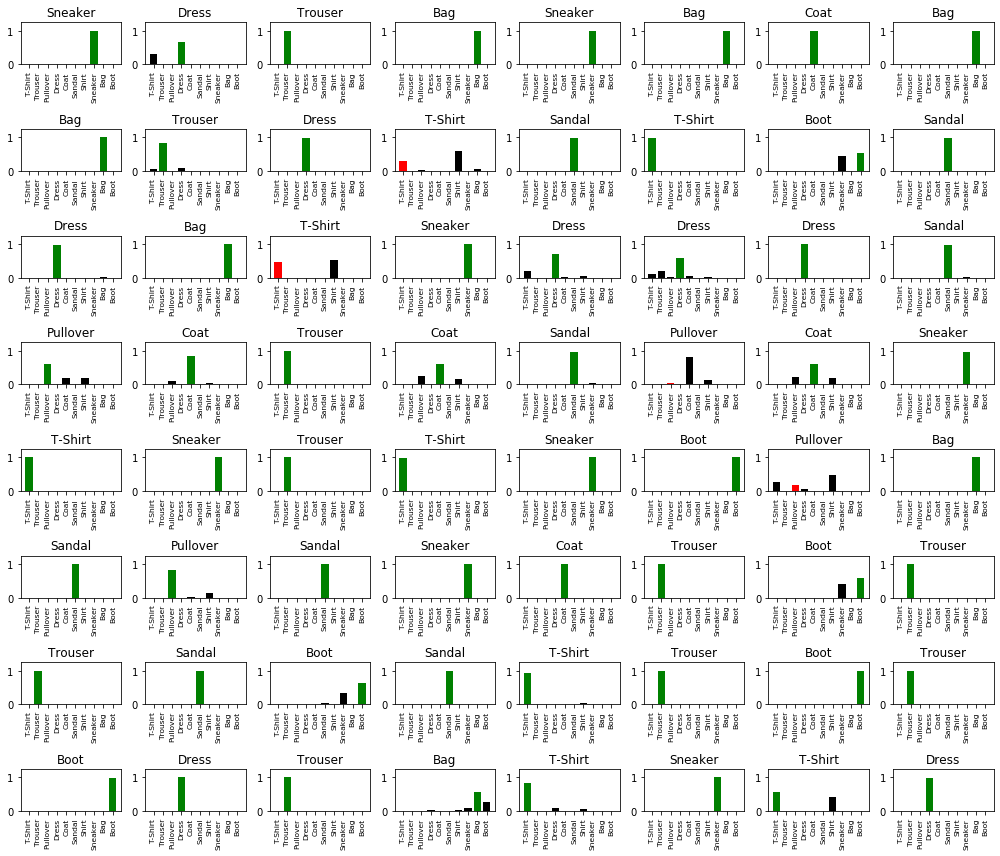

In [15]:
images, labels = next(dataiter)

misclassified = showclassp(images, labels, model, misclassified=True)

The misclassified images for this particular batch are the following (notice the benefit of `namedtuple` to store this kind of information):

In [16]:
print(misclassified)

[Misclassified(index=11, true_label=6), Misclassified(index=18, true_label=6), Misclassified(index=29, true_label=4), Misclassified(index=38, true_label=6)]


We can also plot all the misclassified examples:

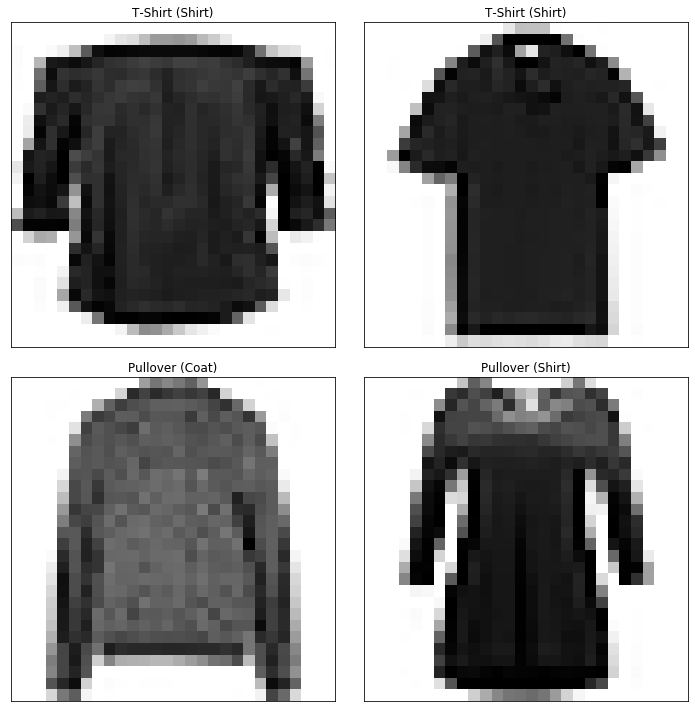

In [17]:
# Define grid size for the subplot
n = len(misclassified) / 2 if len(misclassified) % 2 == 0 else (len(misclassified) + 1) / 2

fig = plt.figure(figsize=(10,10))
for i, (idx, true_label) in enumerate(misclassified):
    ax = fig.add_subplot(n, n, i + 1, xticks=[], yticks=[])
    
    img = (images[idx].numpy().squeeze() + 0.5) * 0.5 # Un-normalize image
    plt.imshow(img, cmap='Greys')
    
    name = label_to_name[labels[idx].item()]
    true_name = label_to_name[true_label]
    
    ax.set_title(f"{name} ({true_name})", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

We see that the misclassified examples are sometimes difficult for humans too!